In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

disease_data = "..\data\Heart_disease.csv"
df_disease = pd.read_csv(disease_data)

# My chosen dataframe was dataframe 2 
df_two = df_disease.drop(columns=["BMI_cat", "bp_category", "height", "weight"])
df_two = pd.get_dummies(df_two, columns=["gender"])
df_two.rename(columns= {"gender_1" : "female", "gender_2" : "male"}, inplace=True)

X,y = df_two.drop("cardio", axis = "columns"), df_two["cardio"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) 

standard_scaler = StandardScaler()
X_train_scaled= standard_scaler.fit_transform(X_train)
X_test_scaled= standard_scaler.transform(X_test)

In [14]:
df_two

,id,age,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,female,male
0,1,55.38,140,90,3,1,0,0,1,1,34.93,1,0
1,3,48.25,150,100,1,1,0,0,1,1,28.71,0,1
2,12,61.83,130,90,3,3,0,0,1,1,29.98,0,1
3,32,63.10,145,85,2,2,0,0,1,1,36.05,1,0
4,46,60.07,140,90,3,1,0,0,0,1,27.40,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19783,99978,49.82,120,80,1,1,0,0,1,0,24.07,0,1
19784,99985,57.53,120,70,1,1,0,0,1,1,33.67,1,0
19785,99988,56.43,130,90,2,2,0,0,1,0,28.48,1,0
19786,99990,51.45,170,90,1,1,0,0,1,1,21.60,1,0


# Training my chosen dataset and model

My chosen model was a random forest model. These were the scores that it had using the Grid search CV. I have also the best parameters that were evaluated. This was using the standard scaler.

- best score 0.7267866134353808
- best params{'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 200}
- best estimator 0.7310872894333844

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(criterion= "entropy", max_features="log2", n_estimators=200)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy after testing on test data  {accuracy}")


Model Accuracy after testing on test data  0.7349563619660082


# Confusion matrix on my chosen model

              precision    recall  f1-score   support

           0       0.72      0.73      0.72      3102
           1       0.75      0.74      0.75      3429

    accuracy                           0.73      6531
   macro avg       0.73      0.73      0.73      6531
weighted avg       0.74      0.73      0.74      6531



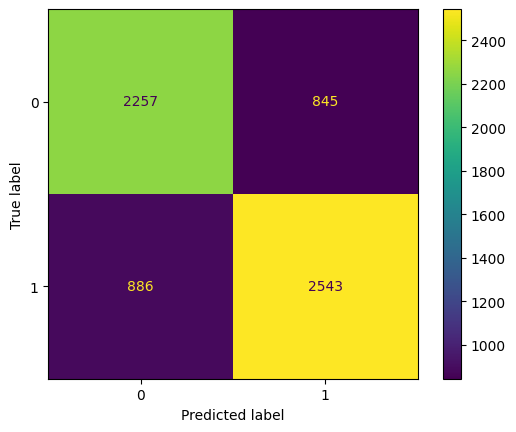

In [16]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

## 2.5 Ensemble

Voting classifier accuracy:0.7314346960649212
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      3102
           1       0.76      0.72      0.74      3429

    accuracy                           0.73      6531
   macro avg       0.73      0.73      0.73      6531
weighted avg       0.73      0.73      0.73      6531



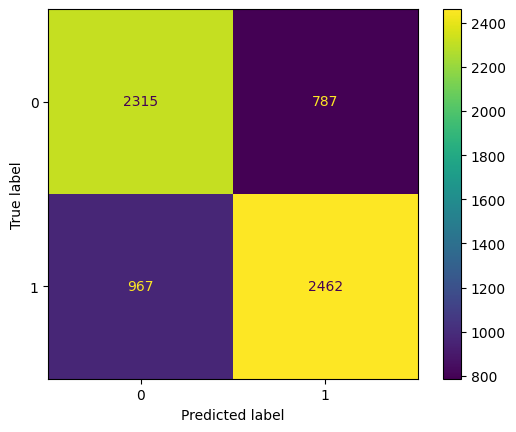

In [38]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

model_1 = RandomForestClassifier(criterion= "entropy", max_features="log2", n_estimators=200)
model_2 = LogisticRegression(C= 0.026366508987303583, penalty="l1",solver="saga")
model_3 = BernoulliNB(alpha=10, binarize=0.0, fit_prior=True)

voting_clf = VotingClassifier(estimators=[("rf", model_1),("lr", model_2), ("bn", model_3)], voting="soft")

voting_clf.fit(X_train_scaled,y_train)

y_pred = voting_clf.predict(X_test_scaled)

print(f"Voting classifier accuracy:{voting_clf.score(X_test_scaled, y_test)}")

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

## 2.7 "Deploy"- save model

### Taking 100 random test samples from the dataframe

In [18]:
remove_rows = df_two.sample(n=100, random_state=42).index

df_test_samples = df_two.loc[remove_rows]

df_train = df_two.drop(remove_rows)

In [19]:
df_test_samples

,id,age,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,female,male
8850,45072,49.84,120,80,1,1,0,0,1,0,31.20,1,0
17318,87510,39.33,120,70,1,1,0,0,1,0,21.83,1,0
2117,10492,43.96,140,90,1,1,0,0,0,1,26.79,0,1
1580,7808,46.17,120,80,1,1,0,0,1,0,39.26,1,0
14342,72009,53.78,120,80,1,1,0,0,1,0,24.90,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14600,73213,53.98,120,80,1,1,0,0,1,0,23.77,0,1
3570,17978,51.20,120,80,1,1,0,0,1,0,21.23,1,0
5083,25580,61.66,140,90,1,1,0,0,1,1,32.41,1,0
19112,96457,55.81,120,80,1,1,0,0,1,0,30.93,1,0


In [20]:
df_train

,id,age,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,female,male
0,1,55.38,140,90,3,1,0,0,1,1,34.93,1,0
1,3,48.25,150,100,1,1,0,0,1,1,28.71,0,1
2,12,61.83,130,90,3,3,0,0,1,1,29.98,0,1
3,32,63.10,145,85,2,2,0,0,1,1,36.05,1,0
4,46,60.07,140,90,3,1,0,0,0,1,27.40,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19783,99978,49.82,120,80,1,1,0,0,1,0,24.07,0,1
19784,99985,57.53,120,70,1,1,0,0,1,1,33.67,1,0
19785,99988,56.43,130,90,2,2,0,0,1,0,28.48,1,0
19786,99990,51.45,170,90,1,1,0,0,1,1,21.60,1,0


In [21]:
df_train.to_csv("..\data\Train_data_disease.csv", index=False)
df_test_samples.to_csv("..\data\Test_data_disease.csv", index=False)

### Training my model on all data except the 100 random chosen data

In [46]:
from sklearn.pipeline import Pipeline

X,y = df_train.drop("cardio", axis = "columns"), df_train["cardio"]

#standard_scaler = StandardScaler()
#X_train = standard_scaler.fit_transform(X)

model_1 = RandomForestClassifier(criterion= "entropy", max_features="log2", n_estimators=200)
model_2 = LogisticRegression(C= 0.026366508987303583, penalty="l1",solver="saga")
model_3 = BernoulliNB(alpha=10, binarize=0.0, fit_prior=True)

voting_clf = VotingClassifier(estimators=[("rf", model_1),("lr", model_2), ("bn", model_3)], voting="soft")

pipe_clf = Pipeline([("scaler", StandardScaler()), ("clf",voting_clf)])

pipe_clf.fit(X,y)

y_pred = pipe_clf.predict(X)

print(f"Voting classifier accuracy:{pipe_clf.score(X, y)}")

Voting classifier accuracy:0.8174522551808208


              precision    recall  f1-score   support

           0       0.80      0.82      0.81      9463
           1       0.83      0.81      0.82     10225

    accuracy                           0.82     19688
   macro avg       0.82      0.82      0.82     19688
weighted avg       0.82      0.82      0.82     19688



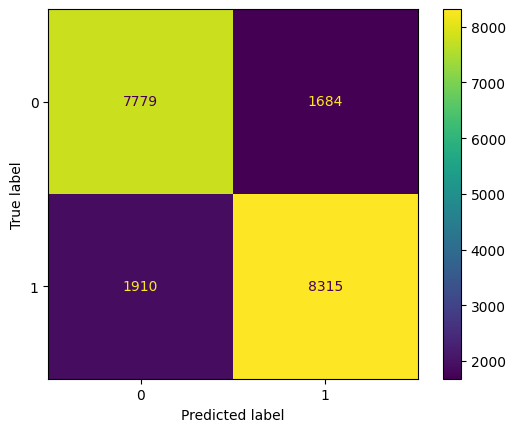

In [47]:
print(classification_report(y, y_pred))
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [37]:
import joblib

joblib.dump(pipe_clf, "voting_classifier.pkl", compress=("gzip", 9))

['voting_classifier.pkl']

In [48]:
import pickle
pickle.dump(pipe_clf, open ("voting_clf_model.pkl", "wb"))